In [190]:
import pandas as pd
import numpy as np
import math

from scipy.stats import spearmanr

from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer

import p1_functions

# Set random seed
np.random.seed(42)

In [191]:
def softmin(z, gamma):
    return (-1 / gamma) * np.log( (1 / (len(z) - 1)) * np.sum(np.exp(-gamma * z)) )

In [192]:
df = pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv")
df_og = df.copy()

# Correct the typo
df.rename(columns = {'Delicassen':'Delicatessen'}, inplace = True)

# Get nominal and numerical attributes
dtype = df.dtypes
cat_features = ["Channel", "Region"] #df[["Channel", "Region"]]
num_features = df.drop(columns=["Channel", "Region"]).columns.tolist()

# Drop meta-data: Channel and the Region indicators
df = df.drop(columns=cat_features)

# Save the original dat set without meta-data
df_og = df.copy()
df_overview = df.copy() # we will use this to append the scores for an overview. Calculations are performed on df

# x ← log(x + 1)
df = np.log(df + 1)

In [193]:
GAMMA = 1

nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)
distances = np.square(distances)

def softmin(z, gamma=1):
    return (-1 / gamma) * np.log( (1 / (len(z) - 1)) * np.sum(np.exp(-gamma * z)) )


df_overview["outlier_score_softmin"] = np.apply_along_axis(softmin, 1, distances[:, 1:], GAMMA)

In [194]:
# The scores are already computed for gamma = 1
outliers = df_overview["outlier_score_softmin"]

mask = outliers > 15
outliers_selected = outliers.argsort()[::-1][:sum(mask)]

In [195]:
def relevance(x, yj, gamma):
    """Calculate layer-wise relevance propagation
    @x: array of instances
    @yj: softmin scores of all j instances
    @gamma: gamma used for softmin
    """

    Rji = np.zeros(x.shape)

    # calculation per instance
    for j in range(len(x)):

        # mask is used to exclude the current instance j
        mask = np.full((len(x)), True)
        mask[j] = False

        # save xk - xj
        xk_j = x - x[j]

        # calculate zk = ||xj - xk||^2
        zk = np.square(np.linalg.norm(xk_j, axis=1))

        # 1. First, one identifies to what extent each data point has contributed to the anomaly score of instance j
        temp = np.exp(-gamma * zk[mask])
        Rk = temp / np.sum(temp) * yj[j]

        # 2. Then, these scores can be propagated back to the input features by observing that the (squared)
        # Euclidean distance entering the anomaly score can be decomposed in terms of individual components:
        Rji[j, :] = np.sum(np.square(xk_j)[mask] / zk[mask][:, None] * Rk[:, None], axis=0)

    return Rji


In [196]:
GAMMA = 1

# Calculate anomaly scores
nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, _ = nbrs.kneighbors(df)
yj = np.apply_along_axis(softmin, 1, np.square(distances[:, 1:]), GAMMA)

x = df.to_numpy()
Rji = relevance(x, yj, GAMMA)

# confirm conservation property
np.all(np.sum(Rji, axis=1) - yj <= 1e-14)

True

# ***************** SUGGESTION FROM HERE *****************

## Reproducibility experiment for the explanations of the anomalies

### Inspection of gamma influence on the robustness of anomaly attribution scores

First, we perform a similar experiment as in Part 2.
For 100 bootstrap samples (n = 220) without replacement we compute the Soft-Min scores for 20 gammas in the range [0.1, 2] and calculate the attribution to the outlierness of each feature.

In [197]:
# 50% random sample without replacement
# for each gamma:
#   calculate anomaly scores for sample instances
#   calculate relevance
#   save relevance (per component) for later analysis

N_BOOTSTRAP = 100
gamma_range = np.linspace(0.1, 2, 20)

Rji_BS = np.full((440, N_BOOTSTRAP, len(gamma_range), 6), np.nan)

for i in range(N_BOOTSTRAP):

    sample = df.sample(frac=0.5)

    nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample)
    distances, _ = nbrs.kneighbors(sample)
    distances = np.square(distances[:, 1:])

    for k, g in enumerate(gamma_range):
        yj = np.apply_along_axis(softmin, 1, distances, g)
        Rji_BS[sample.index, i, k, :] = relevance(sample.to_numpy(), yj, g)

# for each instance, for each sample, for each gamma, the relevance per component
Rji_BS.shape

(440, 100, 20, 6)

For each item we calculate statistics of the anomaly attribution scores over each bootstrap sample. We compute this measure for all gammas. The statistics include mean, variance, and standard deviation.

In [198]:
# Get the statistics over bootstraps
bootstrap_mean = np.nanmean(Rji_BS, axis=1) # all items mean over the boostraps for all gammas for all features
bootstrap_variance = np.nanvar(Rji_BS, axis=1) # all items variance over the boostraps for all gammas for all features
bootstrap_std = np.nanstd(Rji_BS, axis=1) # all items std over the boostraps for all gammas for all features
bootstrap_variance.shape

(440, 20, 6)

We plot the values of the anomaly attribution variances per feature against the gamma values and mark the outliers in blue.

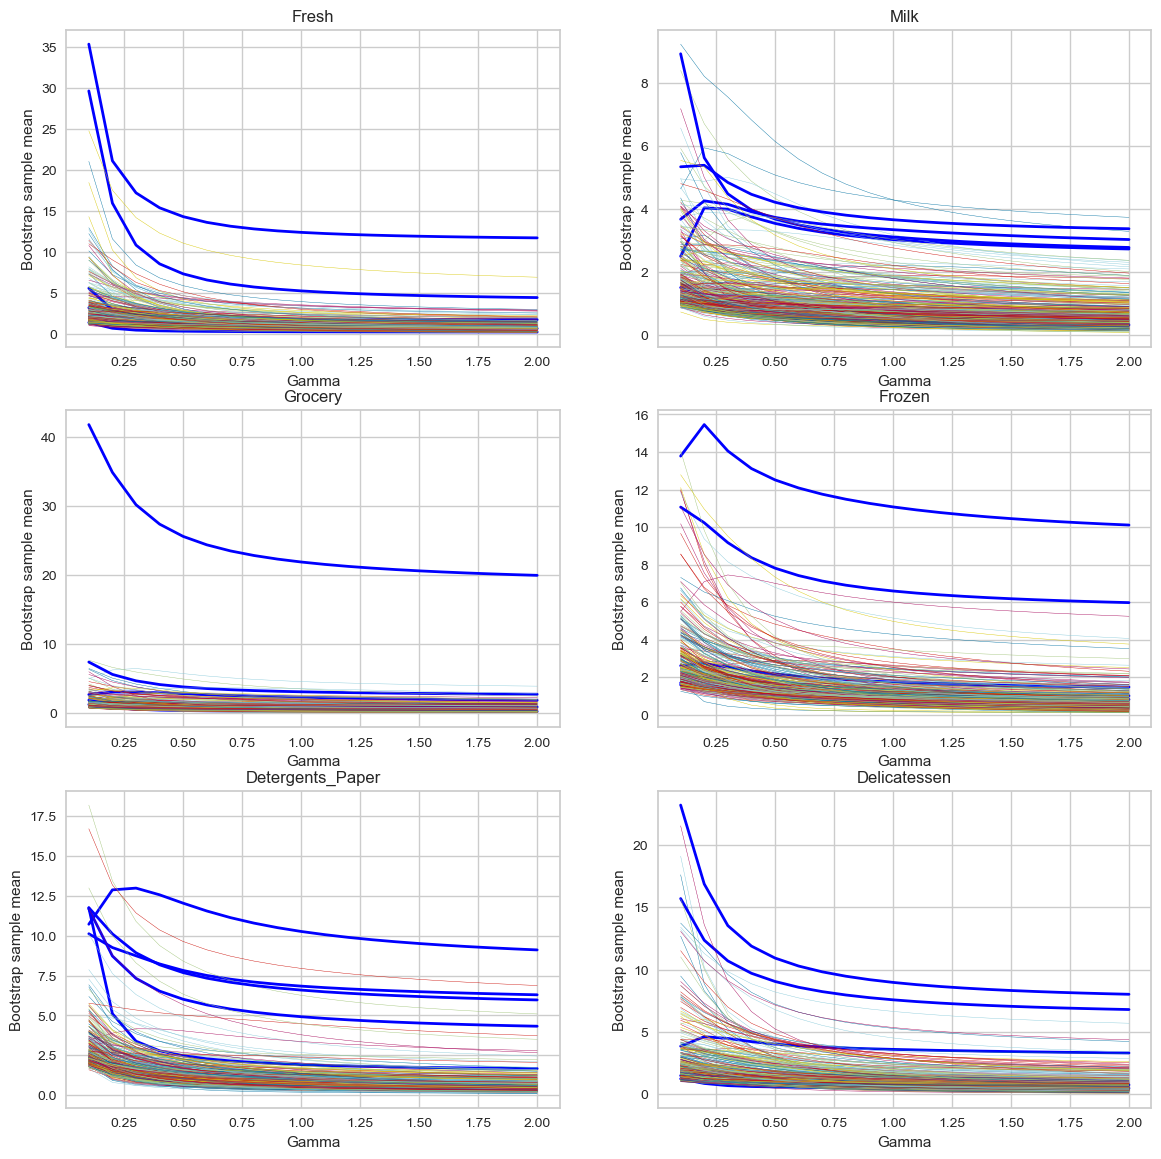

In [199]:
def attribution_stat_plots(statistic, num_features, outliers, type):
    fig = plt.figure(figsize=(14,14))
    gs = gridspec.GridSpec(3,2)
    ax = {}
    for f_ind, feature in enumerate(num_features):
        ax[f_ind] = fig.add_subplot(gs[f_ind])
        ax[f_ind].set(xlabel="Gamma", ylabel="Bootstrap sample " + type, title=feature)

        for item in range(statistic.shape[0]):
            if item in outliers:
                ax[f_ind] = plt.plot(gamma_range, statistic[item,:,f_ind], linewidth=2, c="blue")
            else:
                ax[f_ind] = plt.plot(gamma_range, statistic[item,:,f_ind], linewidth=0.3)

    plt.show()

attribution_stat_plots(bootstrap_mean, num_features, outliers_selected.array, type = "mean")

We plot the values of the anomaly attribution variances per feature against the gamma values and mark the outliers in blue.

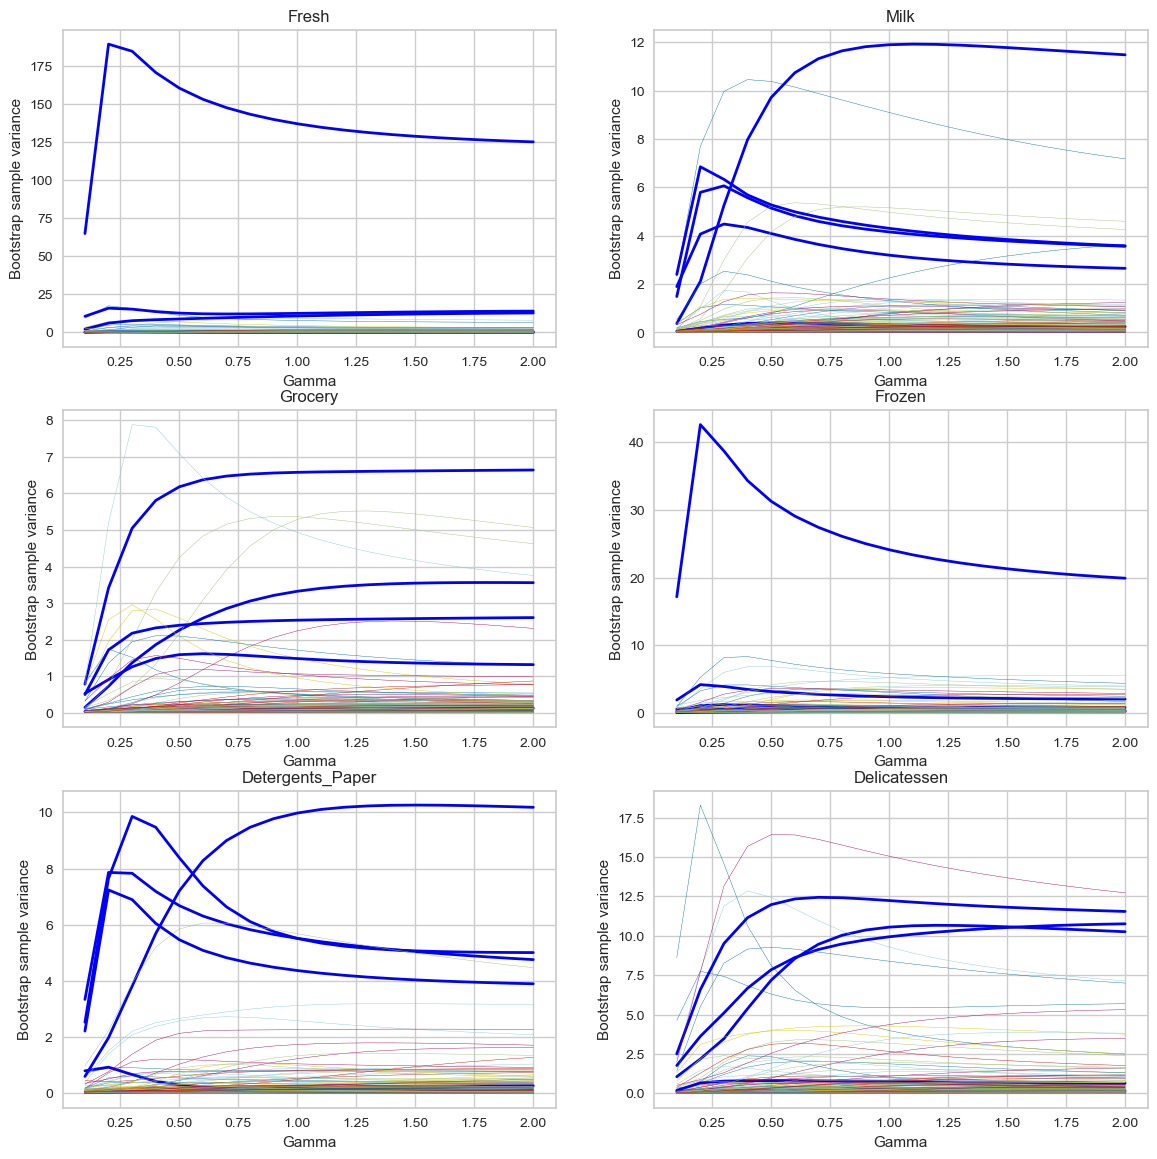

In [200]:
attribution_stat_plots(bootstrap_variance, num_features, outliers_selected.array, type = "variance")

It is visible from the plots that the highest values and the highest variation of the anomaly attribution scores is inherent to the outlier points.


#### NOTE: Not sure how we can interpret the trend for different gammas

We also computed the mean values of attribution variance for each feature. We plot these computations separately for inliers (all points but outliers) and outliers.

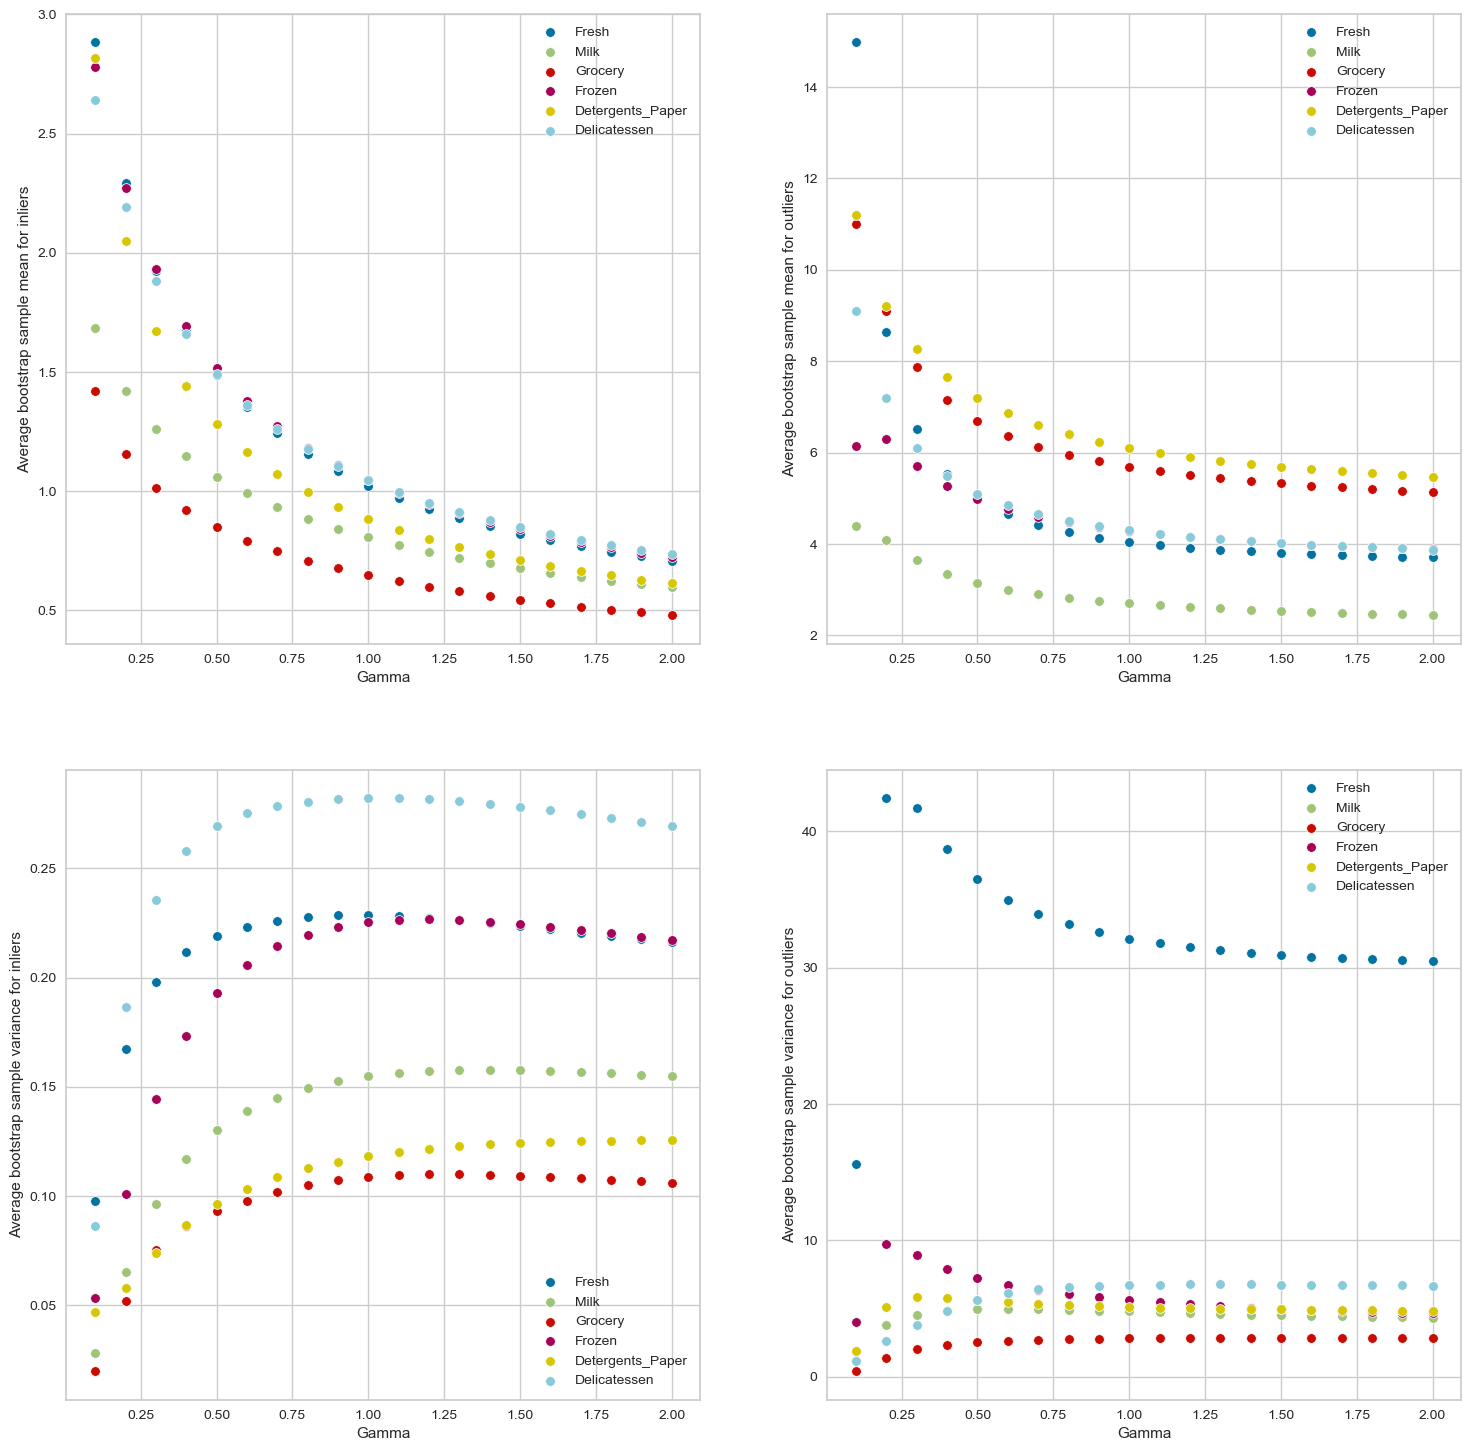

In [201]:
def attribution_variance_means(mean, variance, num_features, outliers, inliers):
    fig = plt.figure(figsize=(18, 18))  # (28,28)
    gs = gridspec.GridSpec(2, 2)
    ax = {}

    ax[0] = fig.add_subplot(gs[0])
    ax[0].set(xlabel="Gamma", ylabel="Average bootstrap sample mean for inliers")
    for f_ind, feature in enumerate(num_features):
        ax[0] = sns.scatterplot(x=gamma_range, y=np.mean(mean[:,:,f_ind][inliers], axis=0), legend=num_features)
    ax[0].legend(labels=num_features)

    ax[1] = fig.add_subplot(gs[1])
    ax[1].set(xlabel="Gamma", ylabel="Average bootstrap sample mean for outliers")
    for f_ind, feature in enumerate(num_features):
        ax[1] = sns.scatterplot(x=gamma_range, y=np.mean(mean[:,:,f_ind][outliers], axis=0))
    ax[1].legend(labels=num_features)

    ax[2] = fig.add_subplot(gs[2])
    ax[2].set(xlabel="Gamma", ylabel="Average bootstrap sample variance for inliers")
    for f_ind, feature in enumerate(num_features):
        ax[2] = sns.scatterplot(x=gamma_range, y=np.mean(variance[:,:,f_ind][inliers], axis=0), legend=num_features)
    ax[2].legend(labels=num_features)

    ax[3] = fig.add_subplot(gs[3])
    ax[3].set(xlabel="Gamma", ylabel="Average bootstrap sample variance for outliers")
    for f_ind, feature in enumerate(num_features):
        ax[3] = sns.scatterplot(x=gamma_range, y=np.mean(variance[:,:,f_ind][outliers], axis=0))
    ax[3].legend(labels=num_features)

    plt.show()

mask = outliers <= 15
inliers = outliers.argsort()[:sum(mask)]

attribution_variance_means(bootstrap_mean, bootstrap_variance, num_features, outliers_selected.array, inliers)

It can be observed that the statistics of the outlier points are in much larger rages.
 Especially the variances of the attribution of the fresh produce are very high.
 The range of the mean variance for the inliers is especially narrow in comparison and the that of outliers.

#### NOTE: Not sure how we can interpret the trend for different gammas

### Inspection of gamma influence on the robustness of anomaly attribution scores
### NOT FINISHED

In order to inspect the robustness for our chosen gamma = 1, we take into account the same statistics of the experiment above only for gamma = 1

In [202]:
# Get the index if gamma = 1 from the experiment
gamma_1_index = np.argwhere(np.around(gamma_range, 1) == 1)[0,0]

# Get the statistics over bootstraps for gamma = 1
bootstrap_mean_g1 = pd.DataFrame(bootstrap_mean[:,gamma_1_index,:], columns = num_features)
bootstrap_var_g1 = pd.DataFrame(bootstrap_variance[:,gamma_1_index,:], columns = num_features)
bootstrap_std_g1 = pd.DataFrame(bootstrap_std[:,gamma_1_index,:], columns = num_features)
bootstrap_var_g1.shape

(440, 6)

We plot a boxplot with and without the extreme values for better comparison between features

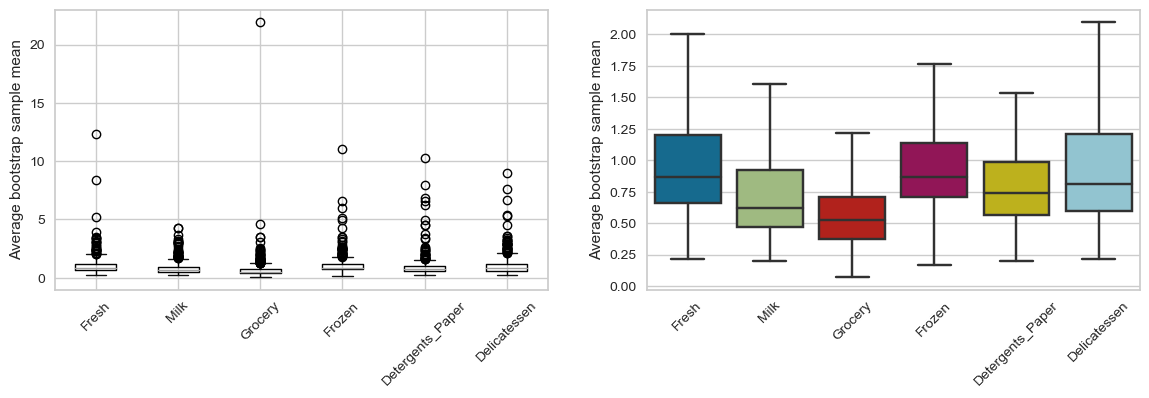

In [203]:
def attribution_boxplots(statistic):
    fig = plt.figure(figsize=(14, 8))  # (28,28)
    gs = gridspec.GridSpec(2, 2)
    ax = {}

    ax[0] = fig.add_subplot(gs[0])
    ax[0].set(ylabel="Average bootstrap sample mean")
    ax[0] = statistic.boxplot()
    ax[0].tick_params(axis='x', rotation=45)

    ax[1] = fig.add_subplot(gs[1])
    ax[1].set(ylabel="Average bootstrap sample mean", )
    ax[1].tick_params(axis='x', rotation=45)
    ax[1] = sns.boxplot(data=statistic, showfliers=False)
    plt.show()

attribution_boxplots(bootstrap_mean_g1)

We can observe that

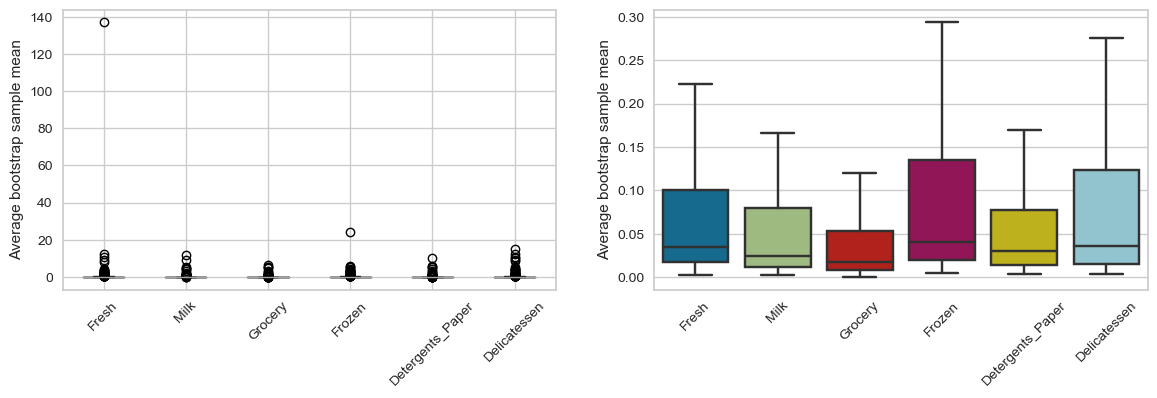

In [204]:
attribution_boxplots(bootstrap_var_g1)

In [205]:
np.mean(Rji, axis=0)

array([0.98715362, 0.83012598, 0.70540016, 1.08000968, 0.9288746 ,
       1.05478014])

In [206]:
np.mean(bootstrap_mean_g1, axis=0)

Fresh               1.057609
Milk                0.827871
Grocery             0.704346
Frozen              1.084090
Detergents_Paper    0.942290
Delicatessen        1.083318
dtype: float64

In [207]:
from scipy import stats
for i in range(len(num_features)):
    corr = stats.pearsonr(Rji[:,i], bootstrap_mean_g1.iloc[:,i])
    print(corr)

PearsonRResult(statistic=0.7085929006087581, pvalue=2.529099290310621e-68)
PearsonRResult(statistic=0.9352188244632625, pvalue=1.2914589201129141e-199)
PearsonRResult(statistic=0.9924082793467818, pvalue=0.0)
PearsonRResult(statistic=0.9720927377261551, pvalue=6.228024124921522e-278)
PearsonRResult(statistic=0.9729271728789852, pvalue=8.851168330987942e-281)
PearsonRResult(statistic=0.9558623119168421, pvalue=4.138546065418289e-235)


In [208]:
for i in range(len(num_features)):
    corr = stats.pearsonr(Rji[:,i], df.iloc[:,i])
    print(corr)

PearsonRResult(statistic=-0.42481726174366885, pvalue=1.0450040928807575e-20)
PearsonRResult(statistic=-0.06865412491711848, pvalue=0.1505188276413156)
PearsonRResult(statistic=-0.29670498677871315, pvalue=2.159156000911055e-10)
PearsonRResult(statistic=-0.1272167360362087, pvalue=0.007544706207477701)
PearsonRResult(statistic=-0.34833699722327627, pvalue=5.3578618692344045e-14)
PearsonRResult(statistic=-0.38421567701699766, pvalue=6.300132139590189e-17)


In [209]:
df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.446992,9.175438,8.930891,5.370638,7.891705,7.199678
1,8.861917,9.191259,9.166284,7.474772,8.099858,7.482682
2,8.756840,9.083529,8.947026,7.785721,8.165364,8.967632
3,9.492960,7.087574,8.348064,8.764834,6.230481,7.489412
4,10.026413,8.596189,8.881697,8.272826,7.483244,8.553718
...,...,...,...,...,...,...
435,10.299037,9.396986,9.682092,9.483112,5.209486,7.698483
436,10.577172,7.266827,6.639876,8.414274,4.543295,7.760893
437,9.584108,9.647885,10.317053,6.082219,9.605216,7.532624
438,9.239025,7.591862,7.711101,6.946014,5.129899,7.661998


In [210]:
bootstrap_mean_g1.iloc[:,0]

0      0.968498
1      0.887999
2      0.796438
3      0.587248
4      0.642748
         ...   
435    0.304986
436    0.873017
437    0.659654
438    0.875591
439    1.916047
Name: Fresh, Length: 440, dtype: float64

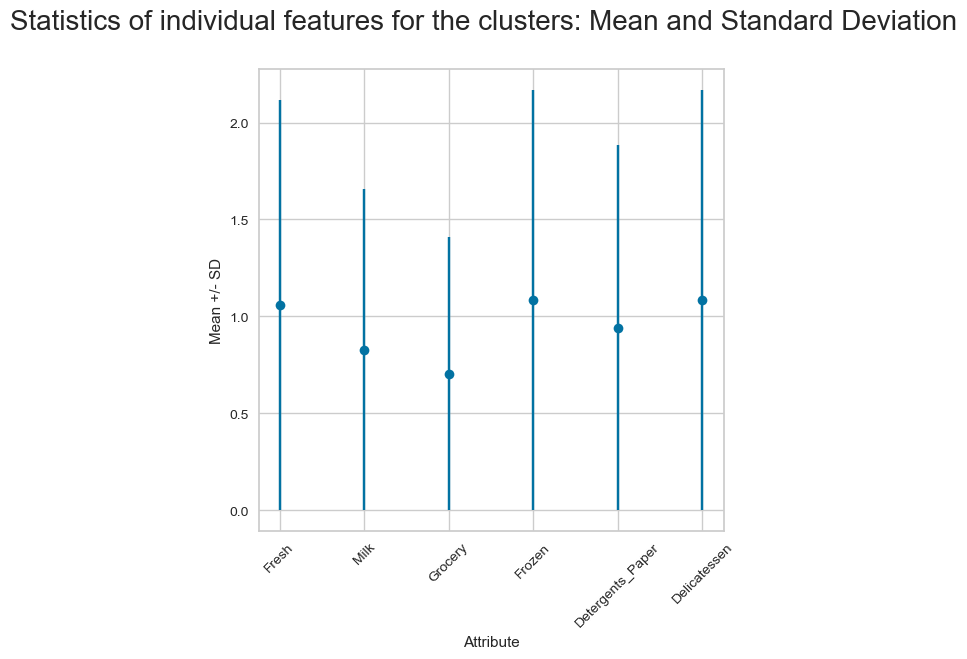

In [211]:
def means(array):
    fig = plt.figure(figsize=(6,6))  # (28,28)
    mean = np.mean(bootstrap_mean_g1,axis=0)
    sd = np.mean(bootstrap_mean_g1,axis=0)

    plt.errorbar(num_features, mean, sd, marker='o', linestyle='None')
    plt.xlabel('Attribute')
    plt.ylabel('Mean +/- SD')
    plt.xticks(rotation=45)
    fig.suptitle("Statistics of individual features for the clusters: Mean and Standard Deviation", fontsize=20)
    plt.show()

means(Rji_BS)